# **Modelling**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
df = pd.read_csv("Datasets/labeled/labeled_data_tweet.csv")
df.rename(columns={'clean_text': 'texts'}, inplace=True)
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head(5)

texts  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive

In [3]:
df.dropna(axis=0, inplace=True)

<AxesSubplot: xlabel='category'>

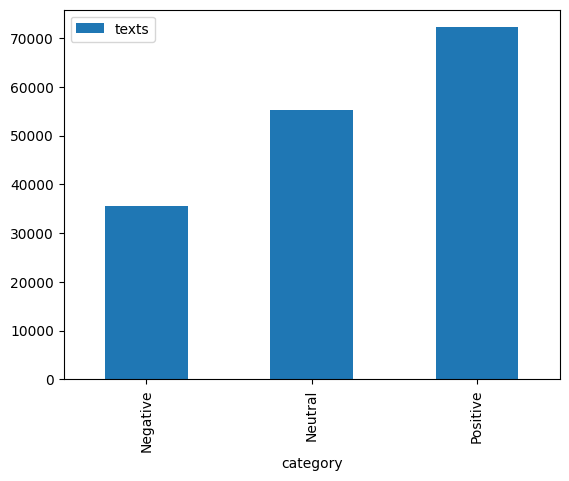

In [4]:
df.groupby('category').count().plot(kind='bar')

<AxesSubplot: >

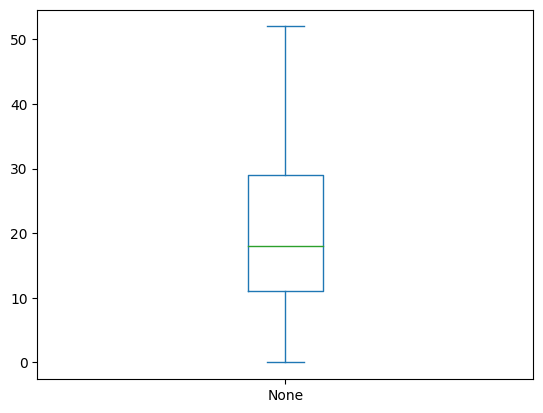

In [5]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['texts']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

In [6]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

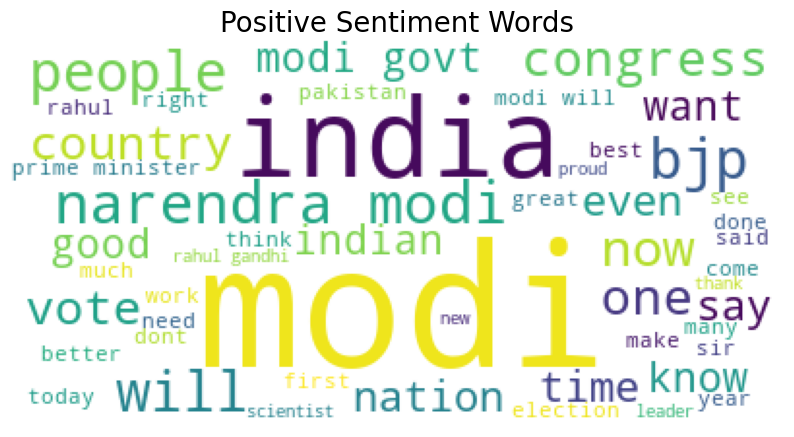

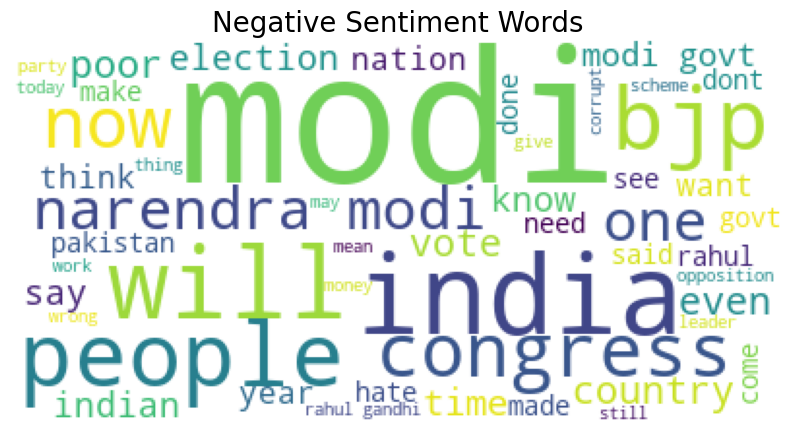

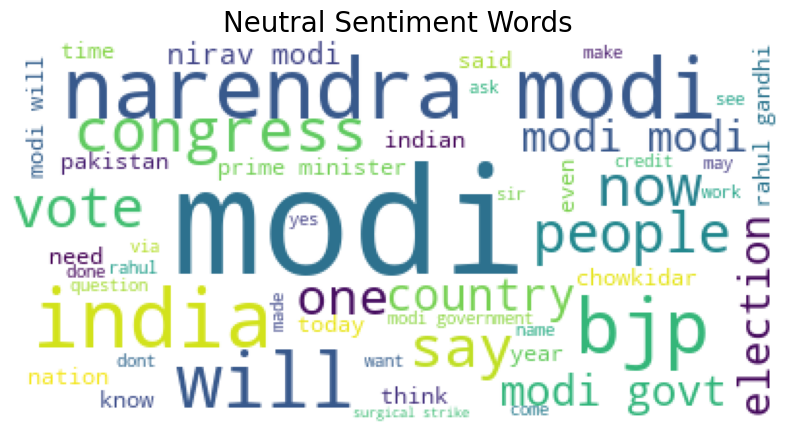

In [7]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['texts']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')
     
# Neutral tweet words
wordcount_gen(df, 'Neutral')

Data preprocessing

In [8]:
# One hot encoding
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

texts  Negative  Neutral  \
0       when modi promised “minimum government maximum...         1        0   
1       talk all the nonsense and continue all the dra...         0        1   
2       what did just say vote for modi  welcome bjp t...         0        0   
3       asking his supporters prefix chowkidar their n...         0        0   
4       answer who among these the most powerful world...         0        0   
...                                                   ...       ...      ...   
162975  why these 456 crores paid neerav modi not reco...         1        0   
162976  dear rss terrorist payal gawar what about modi...         1        0   
162977  did you cover her interaction forum where she ...         0        1   
162978  there big project came into india modi dream p...         0        1   
162979  have you ever listen about like gurukul where ...         0        0   

        Positive  
0              0  
1              0  
2              1  
3              1  
4              1  
...          ...  
162975         0  
162976         0  
162977         0  
162978         0  
162979         1  

[162969 rows x 4 columns]

In [9]:
# Membagi attribut dengan label
sentence = df_baru['texts'].values
label = df_baru[['Negative', 'Neutral', 'Positive']].values

In [10]:
# Membagi data latih dan data testing
from sklearn.model_selection import train_test_split
sentence_latih, sentence_test, label_latih, label_test = train_test_split(sentence, label, test_size=0.2)

In [11]:
# Mengimplementasikan tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(sentence_latih)
tokenizer.fit_on_texts(sentence_test)

sekuens_latih = tokenizer.texts_to_sequences(sentence_latih)
sekuens_test = tokenizer.texts_to_sequences(sentence_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

Modelling ML

In [12]:
# Membuat model dan mengcompile model
import tensorflow as tf
model = tf.keras.Sequential([
  # Menerapkan embedding
  tf.keras.layers.Embedding(input_dim=8000, output_dim=64),
  # Menerapkan LSTM
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32, activation='swish'),
  tf.keras.layers.Dense(16, activation='swish'),
  tf.keras.layers.Dense(3, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
# Mengimplementasikan Callback untuk accuracy diatas 91%
# class Callback_80(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.74:
#       print("\nAkurasi telah mencapai >80%!")
#       self.model.stop_training = True
# callbacks = Callback_80()

In [14]:
# Menjalankan model
num_epochs = 10
history = model.fit(padded_latih, label_latih, epochs=num_epochs, steps_per_epoch=32,
                    validation_data=(padded_test, label_test), verbose=1#, callbacks=[callbacks]
                    )

Epoch 1/10
32/32 [==============================] - 64s 2s/step - loss: 0.8619 - accuracy: 0.6146 - val_loss: 0.5660 - val_accuracy: 0.7578
Epoch 2/10
32/32 [==============================] - 59s 2s/step - loss: 0.3879 - accuracy: 0.8436 - val_loss: 0.2348 - val_accuracy: 0.9259
Epoch 3/10
32/32 [==============================] - 46s 1s/step - loss: 0.1879 - accuracy: 0.9462 - val_loss: 0.1708 - val_accuracy: 0.9528
Epoch 4/10
32/32 [==============================] - 48s 1s/step - loss: 0.1440 - accuracy: 0.9612 - val_loss: 0.1579 - val_accuracy: 0.9571
Epoch 5/10
32/32 [==============================] - 57s 2s/step - loss: 0.1235 - accuracy: 0.9669 - val_loss: 0.1567 - val_accuracy: 0.9590
Epoch 6/10
32/32 [==============================] - 58s 2s/step - loss: 0.1072 - accuracy: 0.9712 - val_loss: 0.1591 - val_accuracy: 0.9584
Epoch 7/10
32/32 [==============================] - 53s 2s/step - loss: 0.0969 - accuracy: 0.9738 - val_loss: 0.1640 - val_accuracy: 0.9594
Epoch 8/10
32/32 [==

<function matplotlib.pyplot.show(close=None, block=None)>

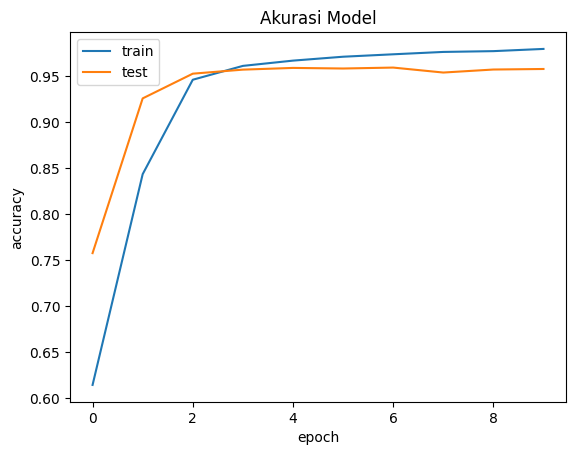

In [15]:
# Membuat plot dari accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

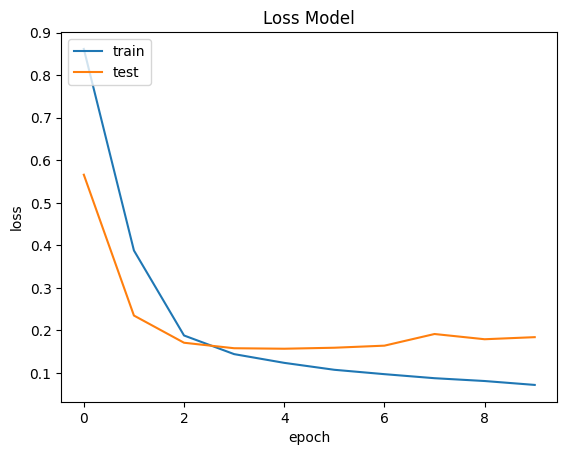

In [16]:
# Membuat plot dari loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show

1019/1019 [==============================] - 11s 9ms/step


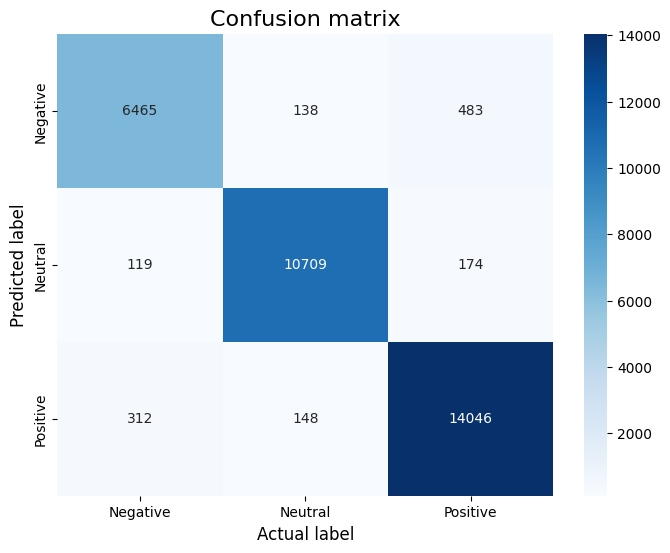

In [17]:
# Membuat confussion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, padded_test, label_test)

In [18]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


Predicting the data

In [28]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt)
    # xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    return sentiment_classes[yt[0]]

In [43]:
df_tweet = pd.read_csv("Datasets/concatenated/clean_full_tweetdata.csv")
df_tweet.head(5)

texts  created_at    location
0  hostility warranted context putin referred wes...  2022-10-03  Noemaville
1  reference hate never seems include view islam ...  2022-10-03         NaN
2                         love edits goku hes muslim  2022-10-03         NaN
3  1400yearold secret pakistan pakistan made alla...  2022-10-03         NaN
4  facts narrative islam fought top 5 guy argumen...  2022-10-03   Bronx, NY

In [60]:
df_tweet.dropna(subset=['texts'], axis=0, inplace=True)
len(df_tweet)

21979

In [61]:
df_tweet['category'] = [predict_class([x]) for x in df_tweet['texts']]

1/1 [==============================] - 0s 139ms/step


In [62]:
df_tweet.head(5)

texts  created_at    location  \
0  hostility warranted context putin referred wes...  2022-10-03  Noemaville   
1  reference hate never seems include view islam ...  2022-10-03         NaN   
2                         love edits goku hes muslim  2022-10-03         NaN   
3  1400yearold secret pakistan pakistan made alla...  2022-10-03         NaN   
4  facts narrative islam fought top 5 guy argumen...  2022-10-03   Bronx, NY   

   category  
0  Positive  
1  Negative  
2  Positive  
3  Negative  
4  Positive

In [63]:
df_tweet.to_csv('Datasets/concatenated/labeled_islam_tweetdata.csv', index = False)

In [64]:
text = 'He is a best minister india ever had seen'
x = predict_class([text])
print("x is " + x)

1/1 [==============================] - 0s 22ms/step
x is Positive
